In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

# sim_name = f"Dopri5_1k"
# sim_folder = f"sim_output_data/{sim_name}"

sim_name = f"SunMod_1k"
sim_folder = f"sim_output/{sim_name}"

# sim_name = f"high_res"
# sim_folder = f"sim_output/{sim_name}"

fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

# Sun apparent motion in Earth(-GC) frame

### Static 3D plot

In [ ]:
year = 2024
sun_positions, sun_velocities_CNB = SimPlot.calculate_sun_position_and_velocity(year)
print(sun_positions.shape)

# Plot the Sun's trajectory in special Earth-GC frame
SimPlot.plot_enhanced_sun_trajectory(sun_positions, elev=20, azim=170)

In [ ]:
sun_tiled = jnp.repeat(sun_positions, 2, axis=0)
print(sun_tiled[0], sun_tiled[-1])
sun_extended = jnp.append(sun_tiled, sun_tiled[0][None,:], axis=0)
print(sun_extended[0], sun_extended[-2:])
print(sun_extended.shape)

In [ ]:
print(sun_velocities_CNB[:3])
print(jnp.linalg.norm(sun_velocities_CNB[:3], axis=-1))

In [ ]:
z_int_steps_all = jnp.load(f'{sim_folder}/z_int_steps_2years.npy')
z_int_steps_all.shape

In [ ]:
# Compare loaded Earth-Sun distances from internet archive to astropy fctn ones
ic(np.linalg.norm(sun_positions, axis=-1).min())
ic(np.linalg.norm(sun_positions, axis=-1).max())
ic(ES_distances.min())
ic(ES_distances.max())

### Animated Solar trajectory in 3D

In [ ]:
def animate_sun_trajectory(sun_positions, sun_velocities, interval=50, subsample=1, save_path=None, freeze_duration=2, elev=30, azim=-60, max_extent=None, dpi=50):
    # Subsample the sun positions and velocities if needed
    positions = sun_positions[::subsample]
    velocities = sun_velocities[::subsample]

    # Calculate the maximum extent of the trajectory
    if max_extent is None:
        max_extent = np.max(np.abs(positions))

    # Scale factor for velocity arrows
    vel_scale = max_extent / np.max(np.linalg.norm(velocities, axis=1)) * 0.2

    # Create a figure with adjusted size
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjust the axes position to fill more of the figure
    ax.set_position([0.1, 0.1, 0.8, 0.8])

    # Set axis limits
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    ax.set_zlim(-max_extent, max_extent)

    # Set labels with smaller font size
    ax.set_xlabel('X (Earth-GC direction)', fontsize=8)
    ax.set_ylabel('Y', fontsize=8)
    ax.set_zlabel('Z', fontsize=8)
    ax.set_title("Sun's Trajectory Relative to Earth (Earth-GC Frame)", fontsize=10)

    # Reduce tick label size
    ax.tick_params(axis='both', which='major', labelsize=6)

    # Plot Earth as a blue sphere at the center
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    earth_radius = 0.05 * max_extent
    ex = earth_radius * np.outer(np.cos(u), np.sin(v))
    ey = earth_radius * np.outer(np.sin(u), np.sin(v))
    ez = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(ex, ey, ez, color='blue', alpha=0.7)

    # Add Earth-GC line (x-axis)
    ax.plot([-max_extent, max_extent], [0, 0], [0, 0], color='red', linestyle='--', label='Earth-GC line')

    # Plot the ecliptic plane
    xx, yy = np.meshgrid(np.linspace(-max_extent, max_extent, 10), np.linspace(-max_extent, max_extent, 10))
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, alpha=0.2, color='cyan')

    # Find the point with maximum z-coordinate
    max_z_index = np.argmax(positions[:, 2])
    max_z_point = positions[max_z_index]

    # Plot line from origin to max_z_point
    ax.plot([0, max_z_point[0]], [0, max_z_point[1]], [0, max_z_point[2]], color='green', linestyle=':', label='Max height line')

    # Initialize the sun trajectory line and point
    line, = ax.plot([], [], [], color='yellow', label='Sun trajectory')
    point, = ax.plot([], [], [], 'yo', markersize=6, label='Sun')

    # Initialize the velocity arrow (we'll update its data in each frame)
    quiver = ax.quiver(0, 0, 0, 0, 0, 0, color='orange', label='Sun velocity (CMB frame)')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Reduce legend font size and move it to a less obtrusive position
    ax.legend(fontsize=6, loc='upper right', bbox_to_anchor=(1, 1))

    # Adjust layout
    plt.tight_layout()

    # Animation update function
    def update(frame):
        if frame < len(positions):
            line.set_data(positions[:frame, 0], positions[:frame, 1])
            line.set_3d_properties(positions[:frame, 2])
            point.set_data(positions[frame:frame+1, 0], positions[frame:frame+1, 1])
            point.set_3d_properties(positions[frame:frame+1, 2])
            
            # Update velocity arrow
            quiver.set_segments([[[positions[frame, 0], positions[frame, 1], positions[frame, 2]],
                                  [positions[frame, 0] + velocities[frame, 0] * vel_scale,
                                   positions[frame, 1] + velocities[frame, 1] * vel_scale,
                                   positions[frame, 2] + velocities[frame, 2] * vel_scale]]])
        else:
            # Freeze frame: show the complete trajectory
            line.set_data(positions[:, 0], positions[:, 1])
            line.set_3d_properties(positions[:, 2])
            point.set_data([], [])
            point.set_3d_properties([])
            quiver.set_segments([[[0, 0, 0], [0, 0, 0]]])  # Hide arrow in freeze frame

        return line, point, quiver

    # Calculate total frames (including freeze frames)
    total_frames = len(positions) + int(freeze_duration * 1000 / interval)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=total_frames, interval=interval, blit=False, repeat=False)

    if save_path:
        # Save the animation with higher DPI
        anim.save(save_path, writer='pillow', fps=1000//interval, dpi=dpi)
    else:
        # Show the plot
        plt.show()

    return anim


# Sun's trajectory animated in special Earth-GC frame for each day of year 2024
year = 2024
sun_positions, sun_velocities = calculate_sun_position_and_velocity(year)
animate_sun_trajectory(
    sun_positions, 
    sun_velocities,
    interval=50, 
    subsample=5, 
    save_path='sun_trajectory_animation_with_CMBarrow.gif', 
    freeze_duration=0.01, 
    elev=20, 
    azim=170,
    dpi=300
)

In [ ]:
def animate_sun_and_earth_trajectory(sun_positions, sun_velocities, earth_velocities, interval=50, subsample=1, save_path=None, freeze_duration=2, elev=30, azim=-60, max_extent=None, dpi=50):
    # Subsample the sun positions and velocities if needed
    positions = sun_positions[::subsample]
    sun_vels = sun_velocities[::subsample]
    earth_vels = earth_velocities[::subsample]

    # Calculate the maximum extent of the trajectory
    if max_extent is None:
        max_extent = np.max(np.abs(positions))

    # Separate scale factors for Sun and Earth velocity arrows
    sun_vel_scale = max_extent / np.max(np.linalg.norm(sun_vels, axis=1)) * 0.2
    earth_vel_scale = max_extent / np.max(np.linalg.norm(earth_vels, axis=1)) * 0.2

    # Create a figure with adjusted size
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjust the axes position to fill more of the figure
    ax.set_position([0.05, 0.05, 0.9, 0.9])

    # Set axis limits
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    ax.set_zlim(-max_extent, max_extent)

    # Set labels with larger font size
    ax.set_xlabel('X (Earth-GC direction)', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title("Sun's Trajectory Relative to Earth (Earth-GC Frame)", fontsize=14)

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Plot Earth as a blue sphere at the center
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    earth_radius = 0.05 * max_extent
    ex = earth_radius * np.outer(np.cos(u), np.sin(v))
    ey = earth_radius * np.outer(np.sin(u), np.sin(v))
    ez = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(ex, ey, ez, color='blue', alpha=0.7)

    # Add Earth-GC line (x-axis)
    ax.plot([-max_extent, max_extent], [0, 0], [0, 0], color='red', linestyle='--', label='Earth-GC line')

    # Plot the ecliptic plane
    xx, yy = np.meshgrid(np.linspace(-max_extent, max_extent, 10), np.linspace(-max_extent, max_extent, 10))
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, alpha=0.2, color='cyan')

    # Find the point with maximum z-coordinate
    max_z_index = np.argmax(positions[:, 2])
    max_z_point = positions[max_z_index]

    # Plot line from origin to max_z_point
    ax.plot([0, max_z_point[0]], [0, max_z_point[1]], [0, max_z_point[2]], color='green', linestyle=':', label='Max height line')

    # Initialize the sun trajectory line and point
    line, = ax.plot([], [], [], color='yellow', label='Sun trajectory')
    point, = ax.plot([], [], [], 'yo', markersize=6, label='Sun')

    # Initialize the velocity arrows (we'll update their data in each frame)
    sun_quiver = ax.quiver(0, 0, 0, 0, 0, 0, color='orange', label='Sun velocity (CMB frame)')
    earth_quiver = ax.quiver(0, 0, 0, 0, 0, 0, color='cyan', linewidth=2, label='Earth velocity')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Adjust legend font size and position
    ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(0.05, 0.95))

    # Animation update function
    def update(frame):
        if frame < len(positions):
            line.set_data(positions[:frame, 0], positions[:frame, 1])
            line.set_3d_properties(positions[:frame, 2])
            point.set_data(positions[frame:frame+1, 0], positions[frame:frame+1, 1])
            point.set_3d_properties(positions[frame:frame+1, 2])
            
            # Update Sun velocity arrow
            sun_quiver.set_segments([[[positions[frame, 0], positions[frame, 1], positions[frame, 2]],
                                      [positions[frame, 0] + sun_vels[frame, 0] * sun_vel_scale,
                                       positions[frame, 1] + sun_vels[frame, 1] * sun_vel_scale,
                                       positions[frame, 2] + sun_vels[frame, 2] * sun_vel_scale]]])
            
            # Update Earth velocity arrow
            earth_quiver.set_segments([[[0, 0, 0],
                                        [earth_vels[frame, 0] * earth_vel_scale,
                                         earth_vels[frame, 1] * earth_vel_scale,
                                         earth_vels[frame, 2] * earth_vel_scale]]])
        else:
            # Freeze frame: show the complete trajectory
            line.set_data(positions[:, 0], positions[:, 1])
            line.set_3d_properties(positions[:, 2])
            point.set_data([], [])
            point.set_3d_properties([])
            sun_quiver.set_segments([[[0, 0, 0], [0, 0, 0]]])  # Hide Sun arrow in freeze frame
            earth_quiver.set_segments([[[0, 0, 0], [0, 0, 0]]])  # Hide Earth arrow in freeze frame

        return line, point, sun_quiver, earth_quiver

    # Calculate total frames (including freeze frames)
    total_frames = len(positions) + int(freeze_duration * 1000 / interval)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=total_frames, interval=interval, blit=False, repeat=False)

    if save_path:
        # Save the animation
        anim.save(save_path, writer='pillow', fps=1000//interval, dpi=dpi)
    else:
        # Show the plot
        plt.show()

    plt.close(fig)
    return anim


# Sun's + Earth's trajectory animated in special Earth-GC frame for each day of year 2024
year = 2024
sun_positions, sun_velocities_cmb, earth_velocities_cmb = calculate_sun_and_earth_position_and_velocity(year)
earth_velocities = earth_velocities_cmb - sun_velocities_cmb

sun_positions *= Params.km/Params.AU

animate_sun_and_earth_trajectory(
    sun_positions, 
    sun_velocities_cmb,
    earth_velocities,
    interval=50, 
    subsample=5, 
    save_path='sun_earth_trajectory_animation.gif', 
    freeze_duration=0.01, 
    elev=20, 
    azim=170,
    dpi=150
)

# Creation of integration steps (z, s and t)

In [40]:
def z_at_age(age):
    
    # Function to calculate redshift for a given age of the universe
    def age_diff(z):
        return cosmo.age(z).to(apu.year).value - age
    
    # Use root_scalar to find the redshift that gives the specified age
    sol = root_scalar(
        age_diff, bracket=[0, 10], method='brentq', xtol=1e-12, rtol=1e-12)
    return sol.root


def get_redshift_array(days):

    # Today's date
    today = Time.now()
    
    # Calculate redshift for each day
    redshifts = jnp.zeros(days)
    age_today = cosmo.age(0).to(apu.year).value  # Age of the universe today
    for day in range(days):

        # Calculate the date for each day of the past year
        past_date = today - day*apu.day
        
        # Calculate the lookback time in years
        lookback_time = (today - past_date).to(apu.year).value
        
        # Calculate the age of the universe at this lookback time
        age_of_universe_then = age_today - lookback_time
        
        # Find the redshift corresponding to this age of the universe
        redshift = z_at_age(age_of_universe_then)
        
        # Store the redshift value in the array
        redshifts = redshifts.at[day].set(redshift)
    
    return redshifts


def s_of_z(z, args):
    """
    Convert redshift to time variable s with eqn. 4.1 in Mertsch et al.
    (2020), keeping only Omega_M and Omega_L in the Hubble eqn. for H(z).

    Args:
        z (float): redshift

    Returns:
        float: time variable s (in [seconds] if 1/H0 factor is included)
    """    

    def s_integrand(z):        

        # We need value of H0 in units of 1/s.
        H0_val = args.H0/(1/args.s)
        a_dot = np.sqrt(args.Omega_M*(1.+z)**3 + args.Omega_L)/(1.+z)*H0_val
        s_int = 1./a_dot

        return s_int

    s_of_z, _ = quad(s_integrand, 0., z)

    return jnp.float64(s_of_z)


# Function to generate t_int_steps using Astropy
def generate_t_int_steps(z_int_steps):
    # Convert z_int_steps to a numpy array if it's not already
    z_int_steps_np = np.array(z_int_steps)
    
    # Calculate lookback times using Astropy
    t_int_steps_astropy = cosmo.lookback_time(z_int_steps_np)
    
    # Convert to seconds and then to a JAX array
    t_int_steps = jnp.array(t_int_steps_astropy.to(apu.s).value)
    
    return t_int_steps


# 2 years plus additional day, s.t. integration routine can pick 2nd last
# (see notes in backtrack_1_neutrino function)
days = (365*2)+1

# Get the redshift array for these (past) days
z_int_steps_2years = get_redshift_array(days)

# Convert to integration variable s
s_int_steps_2years = jnp.array(
    [s_of_z(z, Params()) for z in z_int_steps_2years])

# Convert to "physical" time in seconds
t_int_steps_2years = generate_t_int_steps(z_int_steps_2years)

jnp.save(f"{sim_folder}/z_int_steps_2years.npy", z_int_steps_2years)
jnp.save(f"{sim_folder}/s_int_steps_2years.npy", s_int_steps_2years)
jnp.save(f"{sim_folder}/t_int_steps_2years.npy", t_int_steps_2years)

# Mini-Sim: 1 Pixel

### Run simulation

In [ ]:
@jax.jit
def EOMs_sun_OLD(s_val, y, args):

    # Unpack the input data
    s_int_steps, z_int_steps, t_int_steps, kpc, km, s = args

    # Initialize vector.
    x_i, u_i = y

    # Switch to "numerical reality" here.
    x_i *= kpc
    u_i *= (kpc/s)

    # Find z corresponding to s via interpolation.
    z = Utils.jax_interpolate(s_val, s_int_steps, z_int_steps)

    # Find current position of Sun w.r.t. CNB(==CMB) frame
    sun_position = jnp.array([0,0,0])
    
    # Compute gradient of sun.
    eps = 696_340*km  # solar radius in numerical units
    grad_sun = SimExec.sun_gravity(x_i, eps, sun_position)

    # Switch to "physical reality" here.
    grad_sun /= (kpc/s**2)
    x_i /= kpc
    u_i /= (kpc/s)

    # Relativistic EOMs for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i/(1+z)**2 / jnp.sqrt(jnp.sum(u_i**2) + (1+z)**-2), 
        1/(1+z)**2 * grad_sun
    ])

    return dyds


@jax.jit
def EOMs_sun(s_val, y, args):

    # Unpack the input data
    s_int_steps, z_int_steps, t_int_steps, kpc, km, s = args

    # Initialize vector.
    x_i, u_i = y

    # Switch to "numerical reality" here.
    x_i *= kpc
    u_i *= (kpc/s)

    # Find z (redshift) corresponding to s via interpolation.
    z = Utils.jax_interpolate(s_val, s_int_steps, z_int_steps)

    # Find t (lookback time) corresponding to s via interpolation.
    t = Utils.jax_interpolate(z, z_int_steps, t_int_steps)*s

    # Find current position of Sun w.r.t. CNB(==CMB) frame
    sun_position = SimExec.update_sun_position(t, km, s)
    # sun_position = jnp.array([0,0,0])
    
    # Compute gradient of sun.
    eps = 696_340*km  # solar radius in numerical units
    grad_sun = SimExec.sun_gravity(x_i, eps, sun_position)

    # Switch to "physical reality" here.
    grad_sun /= (kpc/s**2)
    x_i /= kpc
    u_i /= (kpc/s)

    # Relativistic EOMs for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i/(1+z)**2 / jnp.sqrt(jnp.sum(u_i**2) + (1+z)**-2), 
        1/(1+z)**2 * grad_sun
    ])

    return dyds


@jax.jit
def backtrack_1_neutrino(
    init_vector, s_int_steps, z_int_steps, t_int_steps, kpc, km, s):

    """
    Simulate trajectory of 1 neutrino. Input is 6-dim. vector containing starting positions and velocities of neutrino. Solves ODEs given by the EOMs function with an jax-accelerated integration routine, using the diffrax library. Output are the positions and velocities at each timestep, which was specified with diffrax.SaveAt. 
    """

    # Initial vector in correct shape for EOMs function
    y0 = init_vector.reshape(2,3)

    # ODE solver setup
    term = diffrax.ODETerm(EOMs_sun)
    # term = diffrax.ODETerm(EOMs_sun_OLD)
    t0 = s_int_steps[0]
    t1 = s_int_steps[-1]
    dt0 = jnp.median(jnp.diff(s_int_steps)) / 1000

    ### ------------------ ###
    ### Integration Solver ###
    ### ------------------ ###

    solver = diffrax.Dopri5()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)

    # Specify timesteps where solutions should be saved
    # saveat = diffrax.SaveAt(steps=True, ts=jnp.array(s_int_steps))
    saveat = diffrax.SaveAt(ts=jnp.array(s_int_steps))

    # Common arguments for solver
    args = (s_int_steps, z_int_steps, t_int_steps, kpc, km, s)
    
    # Solve the coupled ODEs, i.e. the EOMs of the neutrino
    sol = diffrax.diffeqsolve(
        term, solver, 
        t0=t0, t1=t1, 
        dt0=dt0, 
        y0=y0, max_steps=5000,
        saveat=saveat, 
        stepsize_controller=stepsize_controller,
        args=args, throw=False)

    # Full neutrino trajectory (positions and velocities) for 1 year
    trajectory = sol.ys.reshape(-1,6)

    # note: integration stops close to end_point and timesteps then suddenly
    # note: switch to inf values. So we take [-2] (last finite) values.
    # return jnp.stack([trajectory[0], trajectory[-2]])

    # Keep whole trajectory and stats
    return trajectory, sol.stats, sol.ts


def simulate_neutrinos_1_pix(init_xyz, init_vels, common_args):

    """
    Function for the multiprocessing routine below, which simulates all neutrinos for 1 pixel on the healpix skymap.
    """

    # Neutrinos per pixel
    # nus = init_vels.shape[0]

    # Make vector with same starting position but different velocities
    # init_vectors = jnp.array(
    #     [jnp.concatenate((init_xyz, init_vels[k])) for k in range(nus)])

    # trajectories = jnp.array([
    #     backtrack_1_neutrino(vec, *common_args) for vec in init_vectors])
    
    # return trajectories  # shape = (neutrinos, 2, 6)

    # note: for individual testing
    # """
    init_vector = jnp.concatenate((init_xyz, init_vels))
    # trajectory = backtrack_1_neutrino(
    #     init_vector, *common_args)
    # return trajectory
    trajectory, sol_stats, sol_ts = backtrack_1_neutrino(
        init_vector, *common_args)
    return trajectory, sol_stats, sol_ts
    # """
    


# Load integration time steps
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
t_int_steps = jnp.load(f'{sim_folder}/t_int_steps_1year.npy')

# Initial position (Earth)
init_dis = ES_dists_kpc[0]  # without *kpc units
init_xyz = np.array([init_dis, 0., 0.])
# print(init_xyz*Params.kpc/Params.AU)
jnp.save(f'{sim_folder}/init_xyz_modulation.npy', init_xyz)

print(f"*** Simulation for modulation ***")
sim_start = time.perf_counter()

init_vels = np.load(f'{sim_folder}/initial_velocities.npy')  
# shape = (Npix, neutrinos per pixel, 3)

# Simulate all neutrinos along 1 pixel, without multiprocessing
common_args = (
    s_int_steps, z_int_steps, t_int_steps, 
    Params.kpc, Params.km, Params.s)

print(init_xyz.shape, init_vels.shape, init_vels[0,0].shape)

pixel = 300

nu_vector_low, sol_stats_low, sol_ts_low = simulate_neutrinos_1_pix(
    init_xyz, init_vels[pixel,300], common_args)

nu_vector_med, sol_stats_med, sol_ts_med = simulate_neutrinos_1_pix(
    init_xyz, init_vels[pixel,350], common_args)

nu_vector_high, sol_stats_high, sol_ts_high = simulate_neutrinos_1_pix(
    init_xyz, init_vels[pixel,400], common_args)

sim_time = time.perf_counter()-sim_start
print(f"Simulation time: {sim_time:.2f} sec, {sim_time/60.:.2f} min, {sim_time/(60**2):.2f} h")

print(nu_vector_low.shape)
print(nu_vector_med.shape)
print(nu_vector_high.shape)

### Plot multiple trajectories

In [ ]:
def plot_neutrino_trajectories(data, index1, index2):
    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    max_extents = []
    Npix = data.shape[0]

    # Define colors for the two selected neutrinos
    color1 = (0, 0, 1, 0.6)  # Blue with alpha 0.6
    color2 = (0, 1, 1, 0.6)  # Cyan with alpha 0.6

    for direction in range(Npix):
        # Plot the two selected neutrinos for each direction
        for i, neutrino_index in enumerate([index1, index2]):
            # Extract the trajectory for the specified neutrino
            trajectory = data[direction, neutrino_index, :, :3]

            # Find the last non-nan point
            valid_mask = ~np.isnan(trajectory).any(axis=1)
            last_valid_index = np.where(valid_mask)[0][-1] if np.any(valid_mask) else -1
            
            if last_valid_index == -1:
                print(f"No valid data for direction {direction}, neutrino {neutrino_index}")
                continue

            valid_trajectory = trajectory[:last_valid_index + 1]

            # Calculate the maximum extent of the trajectory
            max_extent = np.max(np.abs(valid_trajectory), axis=0)
            max_extents.append(max_extent)

            # Plot the neutrino trajectory
            color = color1 if i == 0 else color2
            label = f'Direction {direction} - Neutrino {neutrino_index}'
            ax.plot(
                valid_trajectory[:, 0], valid_trajectory[:, 1], valid_trajectory[:, 2], 
                color=color, label=label if direction == 0 else "")

            # Plot the end point with a red cross
            end_point = valid_trajectory[-1]
            ax.scatter(
                end_point[0], end_point[1], end_point[2], 
                color='red', marker='x', s=50)

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=100, label='Sun')

    # Set labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title(f'Neutrino Trajectories (Indices {index1} and {index2}) for {Npix} Directions')

    # Set axis limits dynamically based on the maximum extent of all trajectories
    overall_max_extent = np.max(max_extents, axis=0)
    # ax.set_xlim(-overall_max_extent[0], overall_max_extent[0])
    # ax.set_ylim(-overall_max_extent[1], overall_max_extent[1])
    # ax.set_zlim(-overall_max_extent[2], overall_max_extent[2])

    overall_med_extent = np.min(max_extents, axis=0)
    ax.set_xlim(-overall_med_extent[0], overall_med_extent[0])
    ax.set_ylim(-overall_med_extent[1], overall_med_extent[1])
    ax.set_zlim(-overall_med_extent[2], overall_med_extent[2])

    # Add legend
    ax.legend()

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Show the plot
    plt.show()


plot_neutrino_trajectories(nu_vectors_npix, 0, 1)

### Plot single trajectory

In [ ]:
# %matplotlib inline

def plot_single_neutrino_trajectory(trajectory, elev=30, azim=-60, max_extent=None):
    """
    Plot a single neutrino's trajectory, handling both NaN and inf values.
    
    :param trajectory: numpy array of shape (365, 6) containing the neutrino's
                       positions and velocities for each day of the year.
    """
    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract positions (first 3 columns)
    positions = trajectory[:, :3]*Params.kpc/Params.AU

    vel0 = trajectory[:, 3:][0]*(Params.kpc/Params.s)/(Params.km/Params.s)
    print(f"Starting velocity [km/s]: {vel0}")

    print(f"Starting position [AU]: {positions[0]}")

    # Find the last finite point (neither NaN nor inf)
    valid_mask = np.isfinite(positions).all(axis=1)
    last_valid_index = np.where(valid_mask)[0][-1] if np.any(valid_mask) else -1

    if last_valid_index == -1:
        print("No valid data for this neutrino")
        return

    valid_trajectory = positions[:last_valid_index + 1]

    # Calculate the maximum extent of the trajectory
    if max_extent is None:
        max_extent = np.max(np.abs(valid_trajectory))
    else:
        max_extent = max_extent

    # Plot the neutrino trajectory
    ax.plot(
        valid_trajectory[:, 0], valid_trajectory[:, 1], valid_trajectory[:, 2], 
        color='blue', label='Neutrino Trajectory')

    # Plot the end point with a red cross
    end_point = valid_trajectory[-1]
    ax.scatter(
        end_point[0], end_point[1], end_point[2], 
        color='red', marker='x', s=100, label='End Point')

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=300, label='Sun', alpha=0.6)

    # Plot the Suns trajectory over 1 year w.r.t. CNB(==CMB)
    sun_trajectory = SimExec.update_sun_position(
        t_int_steps[:, None]*Params.s, Params.km, Params.s)/Params.AU
    # print(sun_trajectory.shape)

    ax.plot(
        sun_trajectory[:, 0], sun_trajectory[:, 1], sun_trajectory[:, 2], 
        color='yellow', label='Sun Trajectory')
  

    # Plot the initial velocity vector
    start_pos = valid_trajectory[0]
    velocity_scale = max_extent / np.linalg.norm(vel0) * 0.4  # Scale to 20% of plot size
    velocity_vector = -vel0 * velocity_scale
    ax.quiver(start_pos[0], start_pos[1], start_pos[2],
              velocity_vector[0], velocity_vector[1], velocity_vector[2],
              color='orange', label='Initial Velocity', alpha=0.7)

    # Set labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('Single Neutrino Trajectory')

    # Set axis limits dynamically based on the maximum extent of the trajectory
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    ax.set_zlim(-max_extent, max_extent)

    # Add legend
    ax.legend()

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Show the plot
    plt.show()

    # Determine and print the type of non-finite value encountered
    if last_valid_index < len(positions) - 1:
        next_invalid_point = positions[last_valid_index + 1]
        if np.isnan(next_invalid_point).any():
            print("The trajectory contains NaN values after day", last_valid_index)
        elif np.isinf(next_invalid_point).any():
            print("The trajectory contains inf values after day", last_valid_index)
        else:
            print("Unexpected error: non-finite values detected but neither NaN nor inf")
    else:
        print("The entire trajectory contains finite values")


plot_single_neutrino_trajectory(nu_vector_low, elev=30, azim=-60, max_extent=1)
plot_single_neutrino_trajectory(nu_vector_med, elev=30, azim=-60, max_extent=2)
plot_single_neutrino_trajectory(nu_vector_high, elev=30, azim=-60, max_extent=80)

### Animated single trajectory

In [ ]:
from matplotlib.animation import FuncAnimation

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def animate_neutrino_trajectory(trajectory, interval=50, subsample=5, save_path=None, freeze_duration=2, elev=30, azim=-60, max_extent=None):
    # Extract positions (first 3 columns)
    positions = trajectory[:, :3] * Params.kpc / Params.AU
    print(f"Starting position [AU]: {positions[0]}")

    # Extract and calculate initial velocity
    vel0 = trajectory[:, 3:][0] * (Params.kpc/Params.s) / (Params.km/Params.s)
    print(f"Starting velocity [km/s]: {vel0}")

    # Find the last finite point (neither NaN nor inf)
    valid_mask = np.isfinite(positions).all(axis=1)
    valid_trajectory = positions[valid_mask][::subsample]

    # Calculate the maximum extent of the trajectory
    if max_extent is None:
        max_extent = np.max(np.abs(valid_trajectory))

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Set axis limits
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    ax.set_zlim(-max_extent, max_extent)

    # Set labels
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('Neutrino Trajectory Animation')

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=300, label='Sun', alpha=0.6)

    # Sun trajectory during 1 year w.r.t. CNB frame
    sun_trajectory = SimExec.update_sun_position(
        t_int_steps[:, None]*Params.s, Params.km, Params.s)/Params.AU
    sun_valid = sun_trajectory[::subsample]

    # Plot the initial velocity vector
    start_pos = valid_trajectory[0]
    velocity_scale = max_extent / np.linalg.norm(vel0) * 0.4  # Scale to 40% of plot size
    velocity_vector = -vel0 * velocity_scale
    quiver = ax.quiver(start_pos[0], start_pos[1], start_pos[2],
                       velocity_vector[0], velocity_vector[1], velocity_vector[2],
                       color='orange', label='Initial Velocity', alpha=0.7)

    # Initialize the line and point
    sun_line, = ax.plot([], [], [], color='yellow', label='Sun trajectory')
    sun_point, = ax.plot([], [], [], 'yo', markersize=20, alpha=0.7)
    line, = ax.plot([], [], [], color='blue', label='Neutrino trajectory')
    point, = ax.plot([], [], [], 'bo', markersize=10, alpha=0.7)
    end_point, = ax.plot([], [], [], 'rx', markersize=10, label='End Point')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Animation update function
    def update(frame):
        if frame < len(valid_trajectory):
            line.set_data(
                valid_trajectory[:frame, 0], valid_trajectory[:frame, 1])
            line.set_3d_properties(valid_trajectory[:frame, 2])
            point.set_data(
                valid_trajectory[frame:frame+1, 0], 
                valid_trajectory[frame:frame+1, 1])
            point.set_3d_properties(valid_trajectory[frame:frame+1, 2])
            end_point.set_data([], [])
            end_point.set_3d_properties([])
            sun_line.set_data(
                sun_valid[:frame, 0], sun_valid[:frame, 1])
            sun_line.set_3d_properties(sun_valid[:frame, 2])
            sun_point.set_data(
                sun_valid[frame:frame+1, 0], 
                sun_valid[frame:frame+1, 1])
            sun_point.set_3d_properties(sun_valid[frame:frame+1, 2])
        else:
            # Freeze frame: show the complete trajectory and end point
            line.set_data(valid_trajectory[:, 0], valid_trajectory[:, 1])
            line.set_3d_properties(valid_trajectory[:, 2])
            point.set_data([], [])
            point.set_3d_properties([])
            end_point.set_data([valid_trajectory[-1, 0]], [valid_trajectory[-1, 1]])
            end_point.set_3d_properties([valid_trajectory[-1, 2]])
            sun_line.set_data(sun_valid[:, 0], sun_valid[:, 1])
            sun_line.set_3d_properties(sun_valid[:, 2])
            sun_point.set_data([], [])
            sun_point.set_3d_properties([])
        return line, point, end_point, quiver

    # Calculate total frames (including freeze frames)
    total_frames = len(valid_trajectory) + int(freeze_duration * 1000 / interval)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=total_frames,
                         interval=interval, blit=True, repeat=False)

    # Add legend
    ax.legend()

    if save_path:
        # Save the animation
        anim.save(save_path, writer='pillow', fps=1000//interval)
    else:
        # Show the plot
        plt.show()

    return anim


animate_neutrino_trajectory(
    nu_vector_low, 
    interval=50, subsample=5, save_path='sim_plots_neutrino_trajectory_low.gif', freeze_duration=2, elev=30, azim=-60, max_extent=1)

animate_neutrino_trajectory(
    nu_vector_med, 
    interval=50, subsample=3, save_path='sim_plots_neutrino_trajectory_med.gif', freeze_duration=2, elev=30, azim=-60, max_extent=3)

animate_neutrino_trajectory(
    nu_vector_high, 
    interval=50, subsample=3, save_path='sim_plots_neutrino_trajectory_high.gif', freeze_duration=2, elev=30, azim=-60, max_extent=10)

### Check nan/inf consistency

In [ ]:
def check_nan_consistency(data):
    Npix, num_neutrinos, num_days, _ = data.shape
    
    # Initialize with -1 to indicate no NaNs found
    first_nan_day = -1
    consistent = True

    for direction in range(Npix):
        for neutrino in range(num_neutrinos):
            # Find the first day with NaN for this neutrino
            nan_mask = np.isnan(data[direction, neutrino, :, :]).any(axis=1)
            nan_days = np.where(nan_mask)[0]
            
            if len(nan_days) > 0:
                current_first_nan = nan_days[0]
                
                if first_nan_day == -1:
                    # This is the first NaN we've found, set it as the reference
                    first_nan_day = current_first_nan
                elif current_first_nan != first_nan_day:
                    # We found a NaN starting on a different day
                    consistent = False
                    print(f"Inconsistency found: Direction {direction}, Neutrino {neutrino} "
                          f"has first NaN on day {current_first_nan}")
                    return consistent, first_nan_day

    if first_nan_day == -1:
        print("No NaN values found in the dataset.")
    elif consistent:
        print(f"All NaN values consistently start on day {first_nan_day}")
    
    return consistent, first_nan_day


check_nan_consistency(nu_vectors_npix)

# Sim Analysis

## Computing n_nu via PSD interpolation

In [3]:
# Optimized loop structure
@jax.jit
def compute_PSDs_day(y_day_z4_sort, y_z0_sort, FD_vals_z0):
    # Vectorize the interpolation across all dimensions
    PSDs_day = Utils.vectorized_interpolate_1D(
        y_day_z4_sort, y_z0_sort, FD_vals_z0)
    return PSDs_day


# List to store number densities for each day
days_nrs_l = []
n_nu_days_l = []

# Load dipole fractions
# nu_dipole_vals = jnp.load(f"{sim_folder}/nu_dens_dipole_factors.npy")

_, _, earth_velocities_CNB = SimPlot.SunEarthGC_frame_coords(2024)
earth_velocities_CNB *= (Params.km/Params.s)/(Params.kpc/Params.s)

for day in range(0, 365, 12):

    ### ==================== ###
    ### Solar modulation sim ###
    ### ==================== ###

    # Load velocities for current day
    # Insert dimension at beginning to account for multiple halos later
    file_path = f"{sim_folder}/vectors_day{day+1}.npy"

    if os.path.exists(file_path):
        day_vels = jnp.load(file_path)[..., 3:][None, ...]
        print(f"Day {day+1}/365")
        days_nrs_l.append(day+1)
            
        # Velocities from CNB frame (used in simulations) to Earth frame
        day_vels -= earth_velocities_CNB[day]

        # Convert to momentum arrays (p and y)
        p_day, y_day = Physics.velocities_to_momenta_ND_halo_0th_axis(
            v_arr=day_vels,
            m_arr=nu_m_picks,
            args=Params())

        p_day_z0 = p_day[...,0]
        p_day_z4 = p_day[...,-1]
        y_day_z0 = y_day[...,0]
        y_day_z4 = y_day[...,-1]

        # Sort in ascending order of momentum array today
        ind = p_day_z0.argsort(axis=-1)
        p_day_z0_sort = jnp.take_along_axis(p_day_z0, ind, axis=-1)
        p_day_z4_sort = jnp.take_along_axis(p_day_z4, ind, axis=-1)
        y_day_z0_sort = jnp.take_along_axis(y_day_z0, ind, axis=-1)
        y_day_z4_sort = jnp.take_along_axis(y_day_z4, ind, axis=-1)
        

        ### ================== ###
        ### DM halo simulation ###
        ### ================== ###

        # Neutrino velocities
        halo_num = 6
        vels = SimData.load_velocities(sim_dir=sim_folder, halo_num=halo_num)

        # Convert velocities to momenta
        p_arr, y_arr = Physics.velocities_to_momenta_ND_halo_0th_axis(
            v_arr=vels, 
            m_arr=nu_m_picks,
            args=Params())

        p_z0 = p_arr[...,0]
        p_z4 = p_arr[...,-1]
        y_z0 = y_arr[...,0]

        # Sort in ascending order of momentum array today
        ind = p_z0.argsort(axis=-1)
        p_z0_sort = jnp.take_along_axis(p_z0, ind, axis=-1)
        p_z4_sort = jnp.take_along_axis(p_z4, ind, axis=-1)
        y_z0_sort = jnp.take_along_axis(y_z0, ind, axis=-1)

        # note: z0 sorted arrays of days and DM-sim match (i.e are equivalent)

        ### ========================= ###
        ### Phase-space interpolation ###
        ### ========================= ###

        # """
        # PSD of z0 using Fermi-Dirac assumption and Liouville's theorem
        FD_vals_z0 = Physics.Fermi_Dirac(p_z4_sort, Params())
        # (halos, masses, Npix, p_num)

        # Dipole for current day, and synchronize dimensions
        # nu_dipole_day = nu_dipole_vals[day][None, None, :, None]

        # Apply dipole fractions
        # FD_vals_z0 *= nu_dipole_day

        # Linear interpolation (for now) ... to get phase-space for modulation vectors
        # PSD_day_halos_l = []
        # for h in range(halo_num):

        #     PSD_day_masses_l = []
        #     for mi, m in enumerate(nu_m_picks):

        #         PSD_day_pixels_l = []
        #         for pix in range(simdata.Npix):

        #             PSD_day_pixels_l.append(Utils.jax_interpolate_1D(
        #                 x_interp=y_day_z4_sort[h,mi,pix], 
        #                 x_points=y_z0_sort[h,mi,pix], 
        #                 y_points=FD_vals_z0[h,mi,pix]))

        #         PSD_day_masses_l.append(PSD_day_pixels_l)

        #     PSD_day_halos_l.append(PSD_day_masses_l)

        # PSDs_day = jnp.array(PSD_day_halos_l)

        PSDs_day = compute_PSDs_day(
            jnp.repeat(y_day_z4_sort, len(y_z0_sort), axis=0), y_z0_sort, FD_vals_z0)
        # """

        # Fermi-Dirac Phase-space, for testing
        # PSDs_day = Physics.Fermi_Dirac(p_day_z4_sort, Params())


        def plot_PSD_and_interp(mi):
            fig = plt.figure(figsize=(4,4))
            fig.tight_layout()
            ax = fig.add_subplot(111)
            ax.plot(
                y_z0_median[mi], FD_median[mi], 
                color="blue", alpha=0.7, label="Fermi-Dirac")
            ax.scatter(
                y_day1_z0_median[mi], jnp.array(PSD_day_masses_l)[mi], 
                color="red", marker="x", s=10, alpha=0.7, label="Interpolation")
            ax.set_title(fr"PSD")
            ax.set_ylim(1e-2, 1.5*1e0)
            ax.set_xlim(Params.p_start, 1e1)
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlabel(r"$p/T_{\nu,0}$")
            ax.set_ylabel(r"$f_{\oplus,\mathrm{today}}$")
            ax.legend(loc="lower left")
            ax.grid(**Params.grid_dict)
            plt.show(); plt.close()

        # plot_PSD_and_interp(mi=-1)

        

        ### ================================= ###
        ### Compute number densities for day1 ###
        ### ================================= ###

        #? some values are above 0.5, some interpolation issue at the edges?
        PSDs_day = jnp.clip(PSDs_day, a_min=None, a_max=0.5)

        # Integrand in number density expression
        y = p_day_z0_sort**3 * PSDs_day  # dlog integrand
        x = p_day_z0_sort
        n_raw = trap(y, jnp.log(x), axis=-1)

        # Multiply by constants and/or solid angles and convert to 1/cm**3.
        pix_sr = 4*Params.Pi/simdata.Npix
        n_cm3 = pix_sr * Params.g_nu/((2*Params.Pi)**3) * n_raw / (1/Params.cm**3)
        n_cm3_pix = jnp.array(n_cm3)
        n_tot = jnp.sum(n_cm3_pix, axis=-1)

        n_nu_days_l.append(n_tot)
    else:
        pass

jnp.save(f"{sim_folder}/n_nu_days_Earth_frame.npy", jnp.array(n_nu_days_l))
jnp.save(f"{sim_folder}/days_nrs_Earth_frame.npy", jnp.array(days_nrs_l))

Day 1/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 13/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 25/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 37/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 49/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 61/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 73/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 85/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 97/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 109/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 121/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 133/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 145/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 157/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 169/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 181/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 193/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 205/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 217/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 229/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 241/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 253/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 265/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 277/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 289/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 301/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 313/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 325/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 337/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 349/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


Day 361/365


ic| y_day_z4_sort.shape: (1, 5, 768, 1000)
ic| y_z0_sort.shape: (6, 5, 768, 1000)
ic| FD_vals_z0.shape: (6, 5, 768, 1000)


## Deflection angles

In [ ]:
def calculate_deflection_angle(velocity_vectors):
    """
    Calculate the deflection angle between initial and final velocity vectors.
    
    :param velocity_vectors: numpy array of shape (N, 2, 3)
    :return: numpy array of deflection angles in degrees
    """
    z0_vels = velocity_vectors[:, 0, :]
    z4_vels = velocity_vectors[:, -1, :]
    
    # Normalize the vectors
    z0_vels_norm = z0_vels / np.linalg.norm(z0_vels, axis=-1)[:, None]
    z4_vels_norm = z4_vels / np.linalg.norm(z4_vels, axis=-1)[:, None]
    
    # Calculate the dot product
    dot_product = np.sum(z0_vels_norm * z4_vels_norm, axis=-1)
    
    # Clip the dot product to [-1, 1] to avoid numerical errors
    dot_product_clipped = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate the angle in radians and convert to degrees
    angles = np.arccos(dot_product_clipped) * 180 / np.pi
    
    return angles


def analyze_and_plot_deflections(velocity_vectors, bins, exclude_zero):
    """
    Analyze deflection angles and create a plot with median and 1-sigma percentiles.
    The plot range is limited to the min and max found values.
    
    :param velocity_vectors: numpy array of shape (N, 2, 3)
    :param exclude_zero: boolean, if True, exclude zero angles from analysis
    """
    deflection_angles = calculate_deflection_angle(velocity_vectors)
    
    if exclude_zero:
        deflection_angles = deflection_angles[deflection_angles > 0]
        if len(deflection_angles) == 0:
            print("No non-zero deflection angles found. Cannot perform analysis.")
            return

    median = np.median(deflection_angles)
    percentile_16 = np.percentile(deflection_angles, 16)
    percentile_84 = np.percentile(deflection_angles, 84)
    
    min_angle = np.min(deflection_angles)
    max_angle = np.max(deflection_angles)
    
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(deflection_angles, bins=bins, edgecolor='black')
    plt.axvline(
        median, color='r', linestyle='dashed', linewidth=2, 
        label=f'Median: {median:.2f}°')
    plt.axvline(
        percentile_16, color='g', linestyle='dashed', linewidth=2, 
        label=f'16th percentile: {percentile_16:.2f}°')
    plt.axvline(
        percentile_84, color='g', linestyle='dashed', linewidth=2, 
        label=f'84th percentile: {percentile_84:.2f}°')
    
    plt.xlabel('Deflection Angle (degrees)')
    plt.ylabel('Frequency')
    title = 'Distribution of Deflection Angles'
    if exclude_zero:
        title += ' (Excluding Zero Angles)'
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits to min and max found values
    plt.xlim(min_angle, max_angle)
    
    # Adjust y-axis to show full height of the tallest bar
    plt.ylim(0, max(n) * 1.1)
    
    
    print(f"Median deflection angle: {median:.2f}°")
    print(f"1-sigma range: {percentile_16:.2f}° - {percentile_84:.2f}°")
    print(f"Minimum deflection angle: {min_angle:.2f}°")
    print(f"Maximum deflection angle: {max_angle:.2f}°")
    if exclude_zero:
        print(f"Number of non-zero angles: {len(deflection_angles)}")
        print(f"Number of zero angles excluded: {len(velocity_vectors) - len(deflection_angles)}")
    
    plt.show()
    

# """
# For Dopri5_1k folder and solar modulation files
for day in range(1,365)[::90][:4]:

    # Load velocities for current day
    # Insert dimension at beginning to account for multiple halos later
    day_vels = jnp.load(f"{sim_folder}/vectors_day{day+1}.npy")[..., 3:].reshape(-1, 2, 3)

    analyze_and_plot_deflections(day_vels, bins=100, exclude_zero=True)
# """

"""
# For Dopri5_1k folder and DM halo files
for halo_i in range(4):

    # Load velocities for current day
    # Insert dimension at beginning to account for multiple halos later
    day_vels = jnp.load(
        f"{sim_folder}/vectors_halo{halo_i+1}.npy")[..., 3:].reshape(-1, 2, 3)

    analyze_and_plot_deflections(day_vels, bins=100, exclude_zero=True)
"""

"""
# For no_gravity folder
noG_vels = jnp.load(
    f"{sim_folder}/vectors_halo1.npy")[..., 3:].reshape(-1, 2, 3)
analyze_and_plot_deflections(noG_vels, bins=100, exclude_zero=True)
"""

## Using dipole for (CNB -> Earth) frame change

In [ ]:
def calculate_sun_and_earth_position_and_velocity(year):
    # Define the Galactic Center coordinates
    gc = SkyCoord(l=0*apu.degree, b=0*apu.degree, frame='galactic')
    
    # Sun's velocity w.r.t. CMB in galactic coordinates (km/s)
    sun_vel_cmb_gal = np.array([-0.06935679, -0.66222051, 0.74609224]) * 369.82
    
    # Create lists to store the Sun's positions and velocities, and Earth's velocities
    sun_positions = []
    sun_velocities_cmb = []
    earth_velocities_cmb = []
    
    for day in range(365, 0, -1):  # Loop backwards through each day of the year
        # Create Time objects for the current day and the next day at noon UTC
        time = Time(f'{year}-12-31 12:00:00') - (365 - day) * apu.day
        time_next = time + 1 * apu.day
        
        # Get the Earth's position in ICRS coordinates at current and next day (in km)
        earth_icrs = SkyCoord(get_body_barycentric('earth', time), frame='icrs')
        earth_icrs_next = SkyCoord(get_body_barycentric('earth', time_next), frame='icrs')
        
        # Calculate Earth's velocity in ICRS frame (km/s)
        earth_vel_icrs = (earth_icrs_next.cartesian.xyz - earth_icrs.cartesian.xyz).to(apu.km).value / apu.day.to(apu.s)
        
        # Get the Sun's position in GCRS coordinates (relative to Earth) in km
        sun_gcrs = SkyCoord(get_body_barycentric('sun', time), frame='icrs').transform_to(GCRS(obstime=time))
        sun_vector = sun_gcrs.cartesian.xyz.to(apu.km).value
        
        # Transform the Galactic Center to GCRS
        gc_gcrs = gc.transform_to(GCRS(obstime=time))
        
        # Calculate the unit vector pointing from Earth to Galactic Center
        gc_vector = gc_gcrs.cartesian.xyz.value
        gc_unit_vector = gc_vector / np.linalg.norm(gc_vector)
        
        # Define the new coordinate system
        x_axis = gc_unit_vector
        z_axis = np.cross(x_axis, [0, 0, 1])
        z_axis = z_axis / np.linalg.norm(z_axis)
        y_axis = np.cross(z_axis, x_axis)
        
        # Create the rotation matrix
        rotation_matrix = np.column_stack((x_axis, y_axis, z_axis))
        
        # Rotate the Sun's position into the new coordinate system (km)
        sun_rotated = np.dot(rotation_matrix.T, sun_vector)
        
        # Rotate the Sun's velocity w.r.t. CMB into the new coordinate system (km/s)
        sun_vel_cmb_rotated = np.dot(rotation_matrix.T, sun_vel_cmb_gal)
        
        # Rotate Earth's velocity into the new coordinate system (km/s)
        earth_vel_rotated = np.dot(rotation_matrix.T, earth_vel_icrs)
        
        # Calculate Earth's velocity relative to CMB in the rotated frame (km/s)
        earth_vel_cmb_rotated = sun_vel_cmb_rotated + earth_vel_rotated
        
        # Append the rotated position and velocities to the lists
        sun_positions.append(sun_rotated)
        sun_velocities_cmb.append(sun_vel_cmb_rotated)
        earth_velocities_cmb.append(earth_vel_cmb_rotated)
    
    # note: sun_positions: km units ; velocities: km/s units
    return np.array(sun_positions), np.array(sun_velocities_cmb), np.array(earth_velocities_cmb)


def create_dipole_map(velocity_vector, simdata, args):
    
    # Get the theta and phi angles for each pixel
    theta, phi = hp.pix2ang(simdata.Nside, np.arange(simdata.Npix))
    
    # Convert velocity vector to spherical coordinates
    v_mag = np.linalg.norm(velocity_vector)
    v_theta = np.arccos(velocity_vector[2] / v_mag)
    v_phi = np.arctan2(velocity_vector[1], velocity_vector[0])
    
    # Calculate the dipole anisotropy
    cos_angle = np.sin(theta) * np.sin(v_theta) * np.cos(phi - v_phi) + np.cos(theta) * np.cos(v_theta)
    dipole = args.T_CNB * (1 + v_mag * cos_angle)
    
    return dipole


def create_neutrino_density_dipole_animation(year, simdata, Params, sim_folder, fps=2, dpi=100, day_step=5):
    # Get Sun and Earth velocities
    sun_positions, sun_velocities_cmb, earth_velocities_cmb = calculate_sun_and_earth_position_and_velocity(year)

    # Earth velocities in Earth-GC frame
    earth_vels = earth_velocities_cmb - sun_velocities_cmb

    # Convert velocities to km/s
    sun_velocities_cmb *= Params.km/Params.s
    earth_velocities_cmb *= Params.km/Params.s

    nu_ratios_l = []
    frames = []

    for day in range(1, 366, day_step):
        earth_vel_cmb = earth_velocities_cmb[day-1]
        
        # Compute temperature dipole map from combined velocity vector
        T_dipole_map = create_dipole_map(earth_vel_cmb, simdata, Params)

        # Convert to number density map
        N_dipole_map = 3*zeta(3) / (4*Params.Pi**2) * T_dipole_map**3

        # Get increase/decrease factor, i.e. ratio compared to LambdaCDM value
        nu_ratio = N_dipole_map/Params.N0
        nu_ratios_l.append(nu_ratio)

        # Create a new figure for each day
        fig = plt.figure(figsize=(12, 8))
        hp.mollview(
            nu_ratio, 
            title=f"Neutrino Density Dipole - Day {day}", 
            unit=r"$n_\nu / n_{\nu,0}$", 
            cmap="coolwarm",
            fig=fig
        )
        hp.graticule()

        # Save the figure to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=dpi)
        buf.seek(0)
        
        # Read the image and append to frames
        img = plt.imread(buf)
        frames.append(img)
        
        plt.close(fig)

    # Create the animation
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    im = ax.imshow(frames[0])

    def animate(i):
        im.set_array(frames[i])
        return [im]

    anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000//fps, blit=True)

    # Save the animation
    anim.save(f"{sim_folder}/nu_density_dipole_animation.gif", writer='pillow', fps=fps)

    # Save the nu_ratios_l array
    jnp.save(f"{sim_folder}/nu_dens_dipole_factors.npy", jnp.array(nu_ratios_l))

    plt.close(fig)


# Usage
year = 2024
create_neutrino_density_dipole_animation(year, simdata, Params, sim_folder, fps=4, dpi=100, day_step=5)

# Plot outputs

ic| n_nu_days.shape: (31, 6, 5)


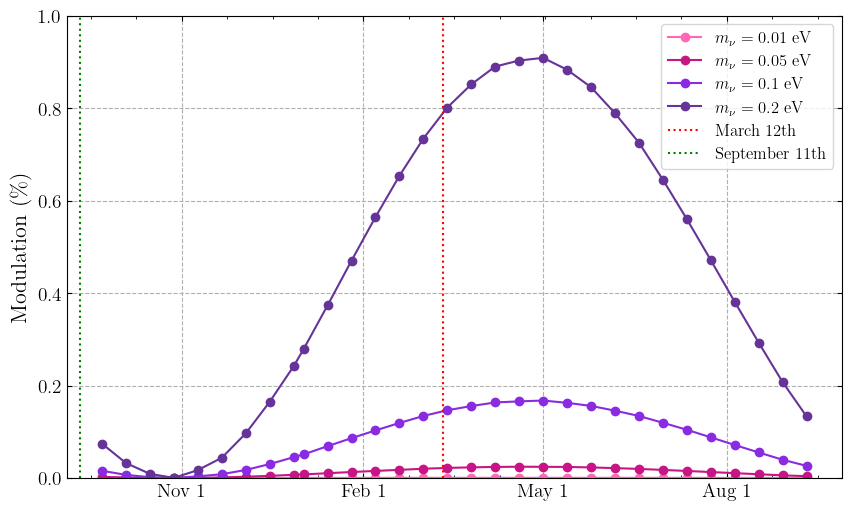

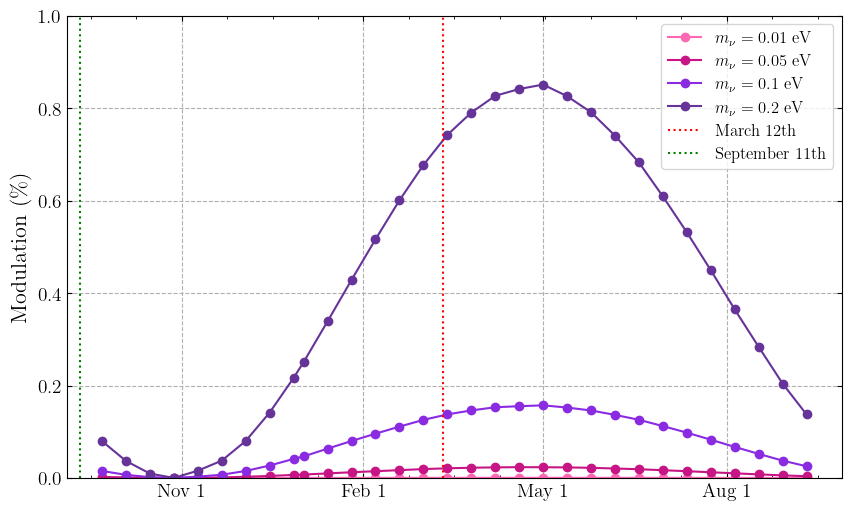

In [5]:
import datetime
def modulation(nu_dens_days, simulated_days, start_date_str='09-11'):

    fig = plt.figure(figsize =(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Shift days to start from the specified date
    shifted_days = (simulated_days - start_day_of_year) % 365 + 1
    sorted_indices = jnp.argsort(shifted_days)
    shifted_days = shifted_days[sorted_indices]

    # Adjust vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1

    violet_colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
        # "pink",
    ]

    for m_idx, (m_val, color) in enumerate(zip(nu_m_picks[:4], violet_colors)):

        nu_dens_m = nu_dens_days[:, m_idx]

        # Compute fractional modulation
        nu_min = jnp.min(nu_dens_m)
        mod = (nu_dens_m - nu_min) / (nu_dens_m + nu_min) * 100
        mod = mod[sorted_indices]

        ax.plot(shifted_days, mod, 'o-', color=color, label=fr"$m_\nu = {m_val}$ eV")

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set x-axis limits
    # plt.xlim(1, 365)
    plt.ylim(0, 1)

    plt.ylabel(r'Modulation ($\%$)')
    plt.legend()
    plt.grid(True, which="major", linestyle="dashed")

    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    plt.savefig(
        f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()


# Load number densities and associated days arrays
n_nu_days = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame.npy")
days_nrs = jnp.load(f"{sim_folder}/days_nrs_Earth_frame.npy")
ic(n_nu_days.shape)

for hi in (0,1):
    modulation(
        nu_dens_days=n_nu_days[:,hi,:]/Params.N0_cm3, 
        simulated_days=days_nrs, start_date_str="09-11")


# n_nu_days_FD = jnp.load(f"{sim_folder}/n_nu_days_FD.npy")
# days_nrs_FD = jnp.load(f"{sim_folder}/days_nrs_FD.npy")

# modulation(
#     nu_dens_days=n_nu_days_FD[:,hi,mi]/Params.N0_cm3, 
#     simulated_days=days_nrs_FD)

n_nu_days shape: (31, 6, 5)


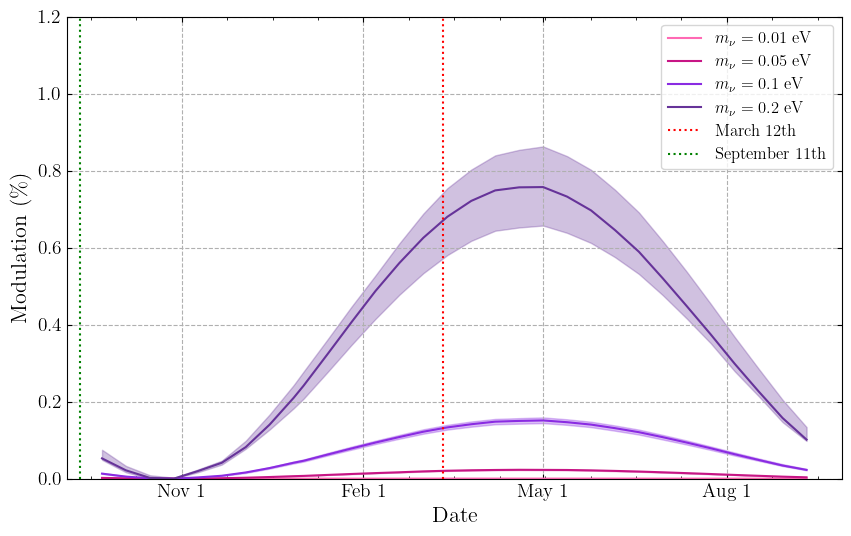

In [7]:

def modulation(nu_dens_days, simulated_days, nu_m_picks, start_date_str='09-11'):
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    # Convert start_date_str to datetime object
    start_date = datetime.datetime.strptime(start_date_str, '%m-%d')
    
    # Calculate the day of the year for the start date
    start_day_of_year = start_date.timetuple().tm_yday

    # Shift days to start from the specified date
    shifted_days = (simulated_days - start_day_of_year) % 365 + 1
    sorted_indices = jnp.argsort(shifted_days)
    shifted_days = shifted_days[sorted_indices]

    # Adjust vertical lines for March 12th and September 11th
    march_12 = (datetime.date(2000, 3, 12) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1
    sept_11 = (datetime.date(2000, 9, 11) - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1

    violet_colors = [
        "hotpink", 
        "mediumvioletred", 
        "blueviolet",
        "rebeccapurple",
    ]

    for m_idx, (m_val, color) in enumerate(zip(nu_m_picks[:4], violet_colors)):
        nu_dens_m = nu_dens_days[:, :, m_idx]  # (days, halos)

        # Compute fractional modulation for each halo
        nu_min = jnp.min(nu_dens_m, axis=0)
        mod = (nu_dens_m - nu_min) / (nu_dens_m + nu_min) * 100

        # Sort modulation values for each day
        mod_sorted = jnp.sort(mod, axis=1)

        # Compute median and 1-sigma band
        median = jnp.median(mod_sorted, axis=1)
        lower = jnp.percentile(mod_sorted, 16, axis=1)
        upper = jnp.percentile(mod_sorted, 84, axis=1)

        # Apply sorting to match shifted_days
        median = median[sorted_indices]
        lower = lower[sorted_indices]
        upper = upper[sorted_indices]

        # Plot median and 1-sigma band
        ax.plot(shifted_days, median, '-', color=color, label=fr"$m_\nu = {m_val}$ eV")
        ax.fill_between(shifted_days, lower, upper, color=color, alpha=0.3)

    # Calculate tick positions and labels
    tick_dates = [datetime.date(2000, 11, 1), datetime.date(2000, 2, 1), 
                  datetime.date(2000, 5, 1), datetime.date(2000, 8, 1)]
    tick_days = [(date - datetime.date(2000, start_date.month, start_date.day)).days % 365 + 1 
                 for date in tick_dates]
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Set axis limits and labels
    plt.ylim(0, 1.2)
    plt.ylabel(r'Modulation ($\%$)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, which="major", linestyle="dashed")

    plt.axvline(x=march_12, color='r', linestyle=':', label='March 12th')
    plt.axvline(x=sept_11, color='g', linestyle=':', label='September 11th')

    plt.legend(prop={"size":12})

    plt.savefig(
        f"{fig_folder}/modulation_1year_Earth_frame_{start_date_str}start_with_uncertainty.pdf",
        bbox_inches="tight")

    plt.show()
    plt.close()

# Load number densities and associated days arrays
n_nu_days = jnp.load(f"{sim_folder}/n_nu_days_Earth_frame.npy")
days_nrs = jnp.load(f"{sim_folder}/days_nrs_Earth_frame.npy")
print(f"n_nu_days shape: {n_nu_days.shape}")

# Call the modulation function with the full n_nu_days array
modulation(
    nu_dens_days=n_nu_days/Params.N0_cm3, 
    simulated_days=days_nrs, 
    nu_m_picks=nu_m_picks,
    start_date_str="09-11")